# Adversarial Attack and Detection in Medical Images using Deap Learning

## Imports
Import common libraries and packages. Also enable autoreload, reloading imported modules each time a cell is run.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%load_ext autoreload
%autoreload 2

## Partition of data
Partition the data defined in a .csv file, where each row holds the file name of images and their corresponding label, into three different .csv files for training, validation and testing under the folder `/data`. You can specify the ratios of training, validation and test data sets.

Once partitioned into these three .csv files, one can use the same partitioning over and over when implementing the model, so to have comparative results.

In [2]:
# # Imports
# from data import partition_data

# # Partition data into training, validation and test sets
# partition_data(file='data/data_labels.csv', ratios=[0.70, 0.15, 0.15], out_path='data/')

## Import and transform data
Import the data as training, validation and test data and augment the images if wanted to.

### Compute mean and standard deviation of data
Compute mean and standard deviation of training data after the pixels have been normalized to [0,1]. Once computed for a given training data set, there's no need to recalculate. Thus, use the computed values in the next cell.

In [3]:
# # Imports
# import albumentations as album
# from albumentations.pytorch import ToTensorV2
# from data import DatasetFromCSV, compute_mean_std

# # Settings
# image_size = 400

# # Compute mean and standard deviation of images in training data
# album_init = album.Compose([album.Resize(image_size, image_size),
#                             album.Normalize(mean=[0,0,0], std=[1,1,1]),
#                             ToTensorV2()])
# dataset_train = DatasetFromCSV(image_root='./data/data_images/',
#                                csv_path='./data/data_labels_train.csv',
#                                transforms=album_init)
# dataset_train_mean, dataset_train_std = compute_mean_std(dataset_train)
# print(dataset_train_mean, dataset_train_std)

In [4]:
# Saved means and standard deviations for each color component
dataset_train_mean = torch.tensor([0.7750, 0.5888, 0.7629])
dataset_train_std = torch.tensor([0.2129, 0.2971, 0.1774])

### Import training and validation data
Import training and validation datasets and put into data loaders. Specify what image size should be used and what augmentations of the data that is executed using the library albumentations. Also plot some examples from each data set.

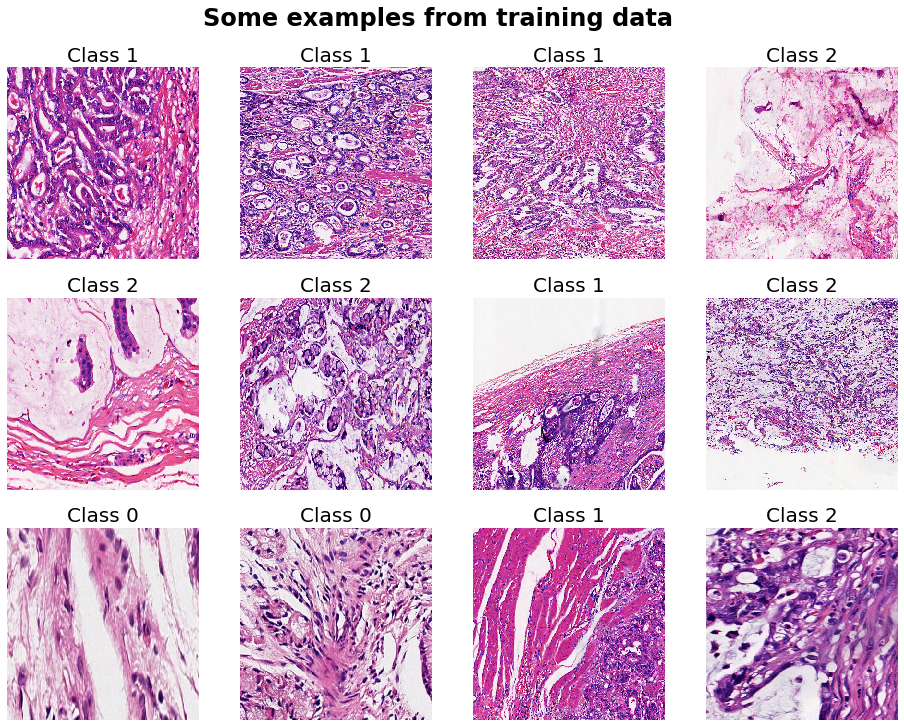

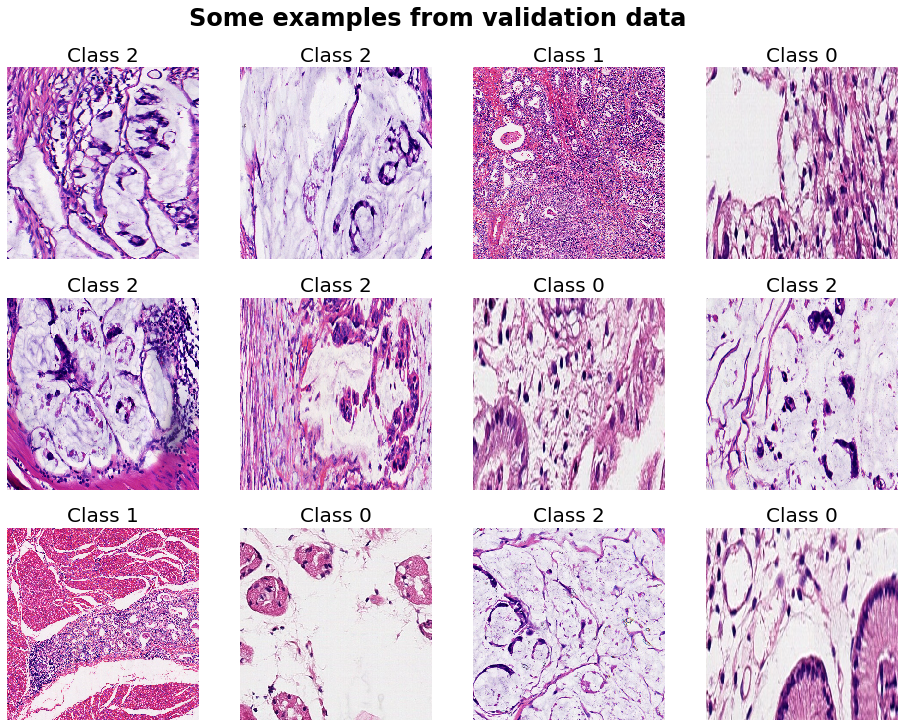

In [5]:
# Imports
import cv2
import albumentations as album
from albumentations.augmentations.transforms import GaussianBlur, MedianBlur, MotionBlur, RandomBrightness, \
                                                    RandomContrast,  VerticalFlip
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch
from data import DatasetFromCSV, compute_mean_std
from plot import plot_dataset, plot_image_list



# Settings
image_size = 400
batch_size = 16
num_workers = 4


# Augmentations of images and data using albumentations
album_train = album.Compose([
    album.Resize(image_size, image_size),
    album.Normalize(mean=[0,0,0], std=[1,1,1], max_pixel_value=255.0),
    album.Normalize(mean=dataset_train_mean, std=dataset_train_std, max_pixel_value=1.0),
    ToTensorV2(),
])

# Load training data set
dataset_train      = DatasetFromCSV(image_root='./data/data_images/',
                                    csv_path='./data/data_labels_train.csv',
                                    transforms=album_train)
# Load validation data set
dataset_validation = DatasetFromCSV(image_root='./data/data_images/',
                                    csv_path='./data/data_labels_validation.csv',
                                    transforms=album_train)


# Plot some examples from training and validation data sets
rows, cols, image_width = 3, 4, 4
fig, axs = plot_dataset(dataset_train, rows=rows, cols=cols, image_width=image_width,
                        mean=dataset_train_mean, std=dataset_train_std)
fig.suptitle('Some examples from training data', fontsize=24, y=0.95, weight='bold')
fig, axs = plot_dataset(dataset_validation, rows=rows, cols=cols, image_width=image_width,
                        mean=dataset_train_mean, std=dataset_train_std)
fig.suptitle('Some examples from validation data', fontsize=24, y=0.95, weight='bold')
plt.show()


# Load data into loaders
loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
loader_validation = DataLoader(dataset=dataset_validation, batch_size=batch_size, num_workers=num_workers)

## Train classifier
Train classifier on training data and save models based on validation results. Can also load pre-trained models. During training, logs are saved and can be viewed via Tensorboard.

In [6]:
# Imports
import os
import time
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
import torch
from torch.utils.tensorboard import SummaryWriter
from models.efficientnet import EfficientNet
from core import core_efficientnet
from utils import create_save_path, SaveBestModel



# Settings
session = 1
num_classes = 3
initial_lr = 0.01
epochs = 100
load_model = True
load_path = './checkpoints/2021-11-05_400x400_100_1/models/last.pt'
save_path = './checkpoints/'+str(datetime.date(datetime.now()))+'_'+\
            str(image_size)+'x'+str(image_size)+'_'+str(epochs)+'_'+str(session)


# Use trained model
if load_model:
    model = torch.load(load_path)
    
    # Device
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Loss function
    loss_func = torch.nn.CrossEntropyLoss().to(device)

    # Optimizer
    optimizer = torch.optim.Adam(lr=initial_lr, params=model.parameters(), betas=(0.9, 0.99))
    
    print('Loaded model:', load_path)

# Train model
else:
    # Model
    model = EfficientNet.from_name('efficientnet-b0', num_classes=num_classes)

    # Device
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Loss function
    loss_func = torch.nn.CrossEntropyLoss().to(device)

    # Optimizer
    optimizer = torch.optim.Adam(lr=initial_lr, params=model.parameters(), betas=(0.9, 0.99))

    # Learning rate decay
    optimizer_step = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)

    # Weight save path
    log_path, weight_path = create_save_path(save_path)

    # Initialize log writer
    log_writer = SummaryWriter(log_path, comment=f'LR_{initial_lr}_BS_{batch_size}')

    # Save current model as best model
    save_best_model = SaveBestModel(epoch=None, model=model, epochs=epochs, monitor_value=None,
                                    weight_path=weight_path, best=None)

    # Setup
    train_total = len(dataset_train)
    valid_total = len(dataset_validation)
    time_start = time.time()

    print('Started:', str(datetime.now()))
    for epoch in range(epochs):
        print('Epoch {:<3}'.format(epoch+1), end='   ')
        
        # Training
        train_acc, train_loss = core_efficientnet.train(model, loader_train, device, loss_func, optimizer,
                                                        train_total, epoch)
        print('Training accuracy: {:>3}%, loss: {:<5}'.format(
            np.around(100*train_acc,2),
            np.around(train_loss,5)),
            end='   ')

        # Validation
        valid_acc, valid_loss = core_efficientnet.valid(model, loader_validation, device, loss_func, optimizer,
                                                        valid_total, epoch)
        print('Validation accuracy: {:>3}%, loss: {:<5}'.format(
            np.around(100*valid_acc,2),
            np.around(valid_loss,5)),
            end='\n')

        # Optimize
        optimizer_step.step()
        lr = optimizer.param_groups[0]['lr']

        # Save model if better than previously best model
        save_best_model.epoch = epoch
        save_best_model.monitor_value = valid_acc
        save_best_model.run(model)

        # Write to log
        log_writer.add_scalar("Train/Training_accuracy", train_acc, epoch)
        log_writer.add_scalar("Train/Validation_accuracy", valid_acc, epoch)
        log_writer.add_scalar("Train/Training_loss", train_loss, epoch)
        log_writer.add_scalar("Train/Validation_loss", valid_loss, epoch)
        log_writer.add_scalar("Train/Learning_rate", lr, epoch)

    time_elapsed = time.time() - time_start
    print('Ended:', str(datetime.now()))
    print('Total training time: {}'.format(str(timedelta(seconds=time_elapsed))))

Loaded model: ./checkpoints/2021-11-05_400x400_100_1/models/last.pt


## Test
Use trained model and get results for test data.

In [7]:
from plot import plot_dataset, plot_image_list

# Augmentations of images and data using albumentations
album_test = album.Compose([
    album.Resize(image_size, image_size),
    album.Normalize(mean=[0,0,0], std=[1,1,1], max_pixel_value=255.0),
    album.Normalize(mean=dataset_train_mean, std=dataset_train_std, max_pixel_value=1.0),
    ToTensorV2(),
])

# Load test data set
dataset_test = DatasetFromCSV(image_root='./data/data_images/',
                              csv_path='./data/data_labels_test.csv',
                              transforms=album_test)

# Load data into loaders
loader_test = DataLoader(dataset=dataset_test, batch_size=batch_size, num_workers=num_workers)

# Test
test_total = len(dataset_test)
test_acc, test_loss, wrong_images, wrong_labels, correct_labels = \
    core_efficientnet.test(model, loader_test, device, loss_func, optimizer, test_total, epoch=1)

print('Test accuracy:   '+str(np.around(100*test_acc,2))+'%')
print('Test loss:       '+str(np.around(test_loss,5)))

Test accuracy:   96.24%
Test loss:       0.1837


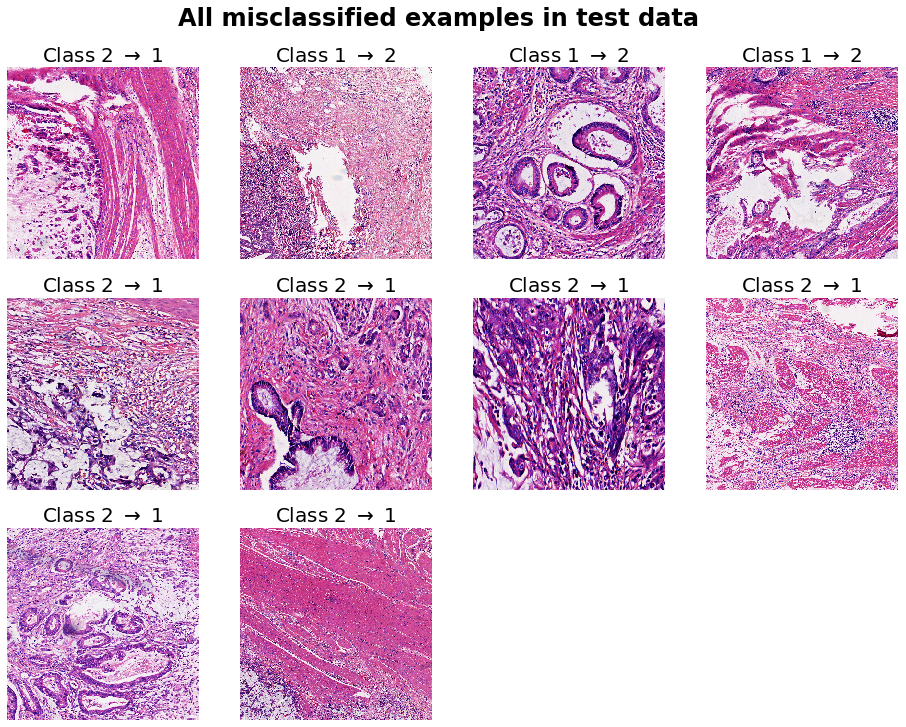

In [8]:
# Plot misclassified samples
rows, cols, image_width = 3, 4, 4
fig, axs = plot_image_list(wrong_images, wrong_labels, correct_labels, rows=rows, cols=cols, image_width=image_width,
                        mean=dataset_train_mean, std=dataset_train_std)
fig.suptitle('All misclassified examples in test data', fontsize=24, y=0.95, weight='bold')
plt.show()

## Attacks

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


RESULTS OF ATTACKS
  True labels:              2 2 0 0 2 0 0 2 1 2 2 0 1 2 1 2 0 2 0 0
  Labels after attack:      0 1 2 1 1 1 1 0 0 0 1 1 2 0 0 0 2 0 2 2
  Wrong prediction:         x x x x x x x x x x x x x x x x x x x x
  Accuracy:                 0.0%

  True labels:              2 2 0 0 2 0 0 2 1 2 2 0 1 2 1 2 0 2 0 0
  Labels after attack:      0 1 2 1 1 1 1 0 0 0 1 1 2 0 0 0 2 0 2 2
  Target labels:            0 1 2 1 1 1 1 0 0 0 1 1 2 0 0 0 2 0 2 2
  Correct target:           o o o o o o o o o o o o o o o o o o o o
  Target accuracy:          100.0%


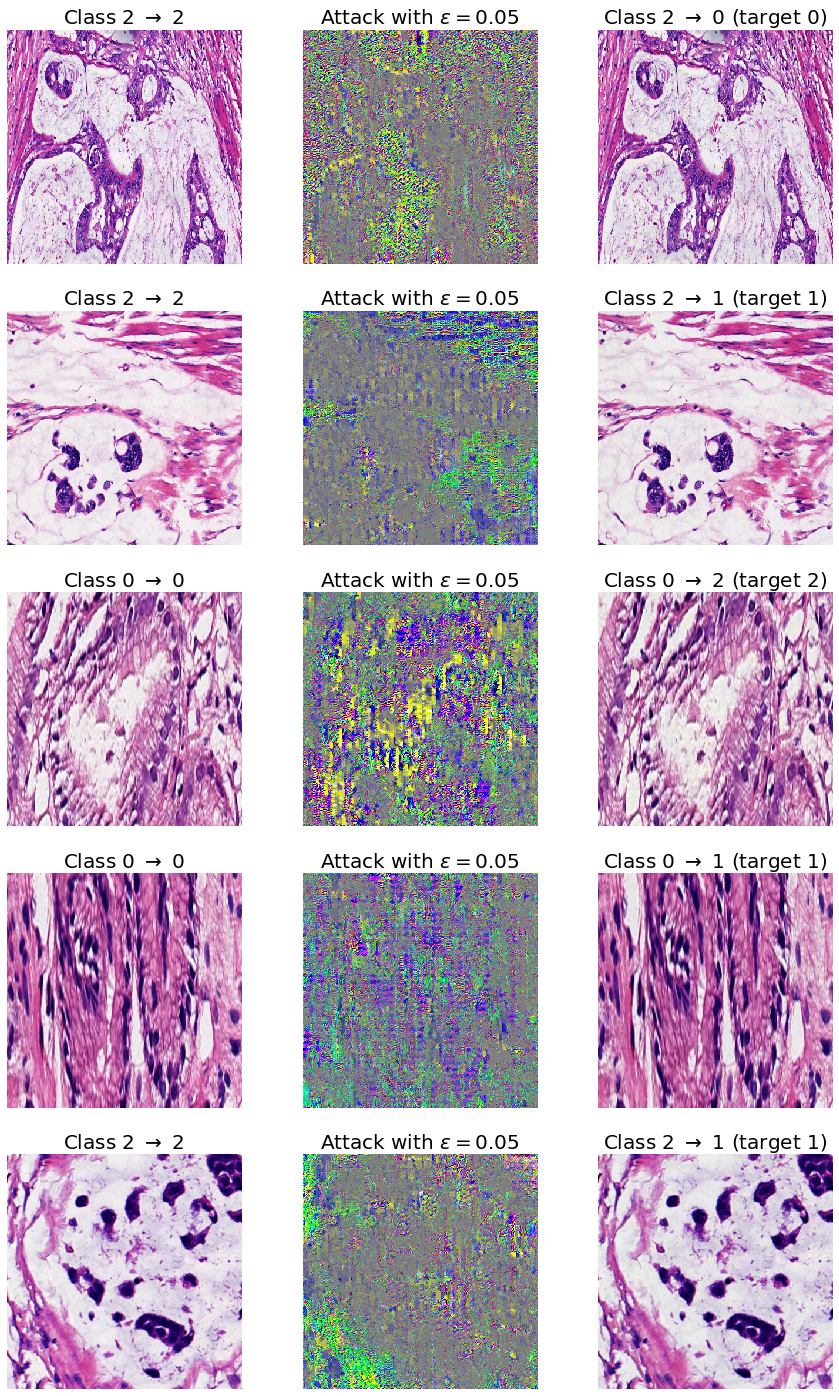

In [70]:
class Attack:
    def __init__(self, name, model, mean, std):
        self.name = name
        self.model = model
        self.mean = mean
        self.std = std
        self.targeted = False
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.loss_function = torch.nn.CrossEntropyLoss()

    def attack(self, *input):
        """
        Function to be implemented for each attack type.
        """
        raise NotImplementedError

    def clamp(self, images):
        """
        Clamp image to min and max values based on mean and standard devation
        for each individual RGB value from training data set.
        """
        data_min = torch.div(-self.mean, self.std)
        data_max = torch.div(1.0 - self.mean, self.std)
        for i, (dmin, dmax) in enumerate(zip(data_min, data_max)):
            images[:,i,:,:] = torch.clamp(input=images[:,i,:,:], min=dmin, max=dmax)
        return images
    
    def renormalize_gradients(self, gradients):
        """
        Since using rescaled and normalzed data, the sign of the gradients needs to be adjusted to the minimum and maximum
        values occuring in the data, so that taking epsilon times the gradients is representative to an image that
        otherwise would have been in range [0,1] for all color components.
        """
        data_min = torch.div(-self.mean, self.std)
        data_max = torch.div(1.0 - self.mean, self.std)
        for i, (dmin, dmax) in enumerate(zip(data_min, data_max)):
            gradients[:,i,:,:] = (gradients[:,i,:,:] + 1.0)/2.0
            gradients[:,i,:,:] = gradients[:,i,:,:]*(dmax - dmin)
            gradients[:,i,:,:] = gradients[:,i,:,:] + dmin
        return gradients

    def get_targeted_labels(self, labels):
        """
        Draw targeted label uniformly from other labels than the actual one.
        """
        targeted_labels = labels.clone()
        for i, label in enumerate(labels):
            targets = [0, 1, 2]
            targets.remove(int(label))
            targeted_labels[i] = np.random.choice(targets)
        return targeted_labels
        

class FGSM(Attack):
    def __init__(self, model, epsilon=0.007, targeted=False, mean=0.0, std=1.0):
        super().__init__('FGSM', model, mean, std)
        self.epsilon = epsilon
        self.targeted = targeted
    
    def attack(self, images, labels):
        """
        FGSM attack algorithm.
        Based on https://adversarial-attacks-pytorch.readthedocs.io/en/latest/attacks.html.
        """
        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)
        loss = self.loss_function.to(self.device)
        
        if self.targeted:
            targeted_labels = self.get_targeted_labels(labels)
        else:
            targeted_labels = None
        
        images.requires_grad = True
        
        outputs = self.model(images)
        
        if self.targeted:
            cost = -loss(outputs, targeted_labels)
        else:
            cost = loss(outputs, labels)
        
        gradients = torch.autograd.grad(cost, images)[0]
        gradients_sign = self.renormalize_gradients(gradients.sign())
        attacked_images = images + self.epsilon*gradients_sign
        attacked_images = self.clamp(attacked_images).detach()
            
        return attacked_images, gradients_sign, targeted_labels


class IFGSM(Attack):
    def __init__(self, model, epsilon=0.007, steps=1, targeted=False, mean=0.0, std=1.0):
        super().__init__('FGSM', model, mean, std)
        self.epsilon = epsilon
        self.steps = steps
        self.targeted = targeted
    
    def attack(self, images, labels):
        """
        IFGSM attack algorithm.
        Based on https://adversarial-attacks-pytorch.readthedocs.io/en/latest/attacks.html.
        """
        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)
        loss = self.loss_function.to(self.device)
        
        if self.targeted:
            targeted_labels = self.get_targeted_labels(labels)
        else:
            targeted_labels = None
        
        original_images = images.clone().detach()
        gradients_sum = 0
        
        for step in range(self.steps):
            images.requires_grad = True
            
            outputs = self.model(images)
            
            if self.targeted:
                cost = -loss(outputs, targeted_labels)
            else:
                cost = loss(outputs, labels)

            gradients = torch.autograd.grad(cost, images)[0]
            gradients_sign = self.renormalize_gradients(gradients.sign())
            attacked_images = images + (self.epsilon/self.steps)*gradients_sign
            attacked_images = self.clamp(attacked_images).detach()
            images = attacked_images
            
            gradients_sum = gradients_sum + gradients_sign

        return attacked_images, gradients_sum/steps, targeted_labels
    

    
def convert_image(image, mean, std):
    """
    Helper function to normalize image to the range [0,1] again.
    """
    image = image.permute(1,2,0).numpy()
    mean_inv = torch.div(-mean, std)
    std_inv = torch.div(1, std)
    album_inv = album.Compose([album.Normalize(mean=mean_inv, std=std_inv, max_pixel_value=1.0)])
    image = album_inv(image=image)['image']
    return image


def plot_attacks(rows, images, labels, init_labels, attacked_images, attacked_labels, gradients,
                 epsilon, mean, std, targeted_labels=None):
    """
    Plot original images, the pertubation and attacked images side by side.
    """
    fig, axs = plt.subplots(rows, 3, figsize=(15,5*rows))
    for i, (img, lbl, init_lbl, att_img, att_lbl, grad) in enumerate(
        zip(images, labels, init_labels, attacked_images, attacked_labels, gradients)):
        ax = axs[i]
        img = convert_image(img, mean, std)
        grad = convert_image(grad, mean, std)
        att_img = convert_image(att_img, mean, std)
        ax[0].imshow(img)
        ax[0].set_title(r'Class {} $\rightarrow$ {}'.format(lbl, init_lbl), fontsize=20)
        ax[1].imshow(grad)
        ax[1].set_title('Attack with $\epsilon='+str(np.around(epsilon,5))+'$', fontsize=20)
        ax[2].imshow(att_img)
        ax[2].set_title(r'Class {} $\rightarrow$ {}{}'.format(lbl, att_lbl,
            ' (target '+str(int(targeted_labels[i]))+')' if targeted_labels is not None else ''), fontsize=20)
        for a in ax:
            a.axis('off')
        if i >= rows-1:
            break
    return fig, axs


def evaluate_attacks(model, labels, attacked_images, attacked_labels, targeted_labels=None):
    """
    Print statistics and information regarding the attacks.
    """
    num_samples = labels.shape[0]
    out = '  {:<25} {}'
    print('RESULTS OF ATTACKS')
    print(out.format('True labels:',         
                     ' '.join([str(int(lbl)) for lbl in labels])))
    print(out.format('Labels after attack:',
                     ' '.join([str(int(lbl)) for lbl in attacked_labels])))
    print(out.format('Wrong prediction:',
                     ' '.join(['x' if labels[i]!=attacked_labels[i] else ' ' for i in range(len(labels))])))
    print(out.format('Accuracy:',
                     str(np.around(np.count_nonzero(attacked_labels==labels)*100/num_samples, 2))+str('%')))
    if targeted_labels is not None:
        print('')
        print(out.format('True labels:',         
                 ' '.join([str(int(lbl)) for lbl in labels])))
        print(out.format('Labels after attack:',
                         ' '.join([str(int(lbl)) for lbl in attacked_labels])))
        print(out.format('Target labels:',
                         ' '.join([str(int(lbl)) for lbl in targeted_labels])))
        print(out.format('Correct target:',
                         ' '.join(['o' if targeted_labels[i]==attacked_labels[i] else ' ' for i in range(len(labels))])))
        print(out.format('Target accuracy:',
                         str(np.around(np.count_nonzero(attacked_labels==targeted_labels)*100/num_samples, 2))+str('%')))



# Load mean and standard deviation of data
dataset_train_mean = torch.tensor([0.7750, 0.5888, 0.7629])
dataset_train_std = torch.tensor([0.2129, 0.2971, 0.1774])

# Load trained model
model = torch.load('./checkpoints/2021-11-05_400x400_100_1/models/last.pt')
    
# Augmentations of images and data using albumentations
album_attack = album.Compose([
    album.Resize(image_size, image_size),
    album.Normalize(mean=[0,0,0], std=[1,1,1], max_pixel_value=255.0),
    album.Normalize(mean=dataset_train_mean, std=dataset_train_std, max_pixel_value=1.0),
    ToTensorV2(),
])

# Load test data set
batch_size = 1
shuffle = False
dataset_attack = DatasetFromCSV(image_root='./data/data_images/',
                                csv_path='./data/data_labels_test.csv',
                                transforms=album_attack)
loader_attack = DataLoader(dataset=dataset_attack, batch_size=batch_size, shuffle=shuffle)



# Set up attack
epsilon = 0.05
steps = 20
targeted = True
max_batches = 20

# Initialize attackers
fgsm = FGSM(model=model, epsilon=epsilon, targeted=targeted,
            mean=dataset_train_mean, std=dataset_train_std)
ifgsm = IFGSM(model= model, epsilon=epsilon, steps=steps, targeted=targeted,
              mean=dataset_train_mean, std=dataset_train_std)

# Choose attacker
attacker = ifgsm



# Intialize reults arrays
all_images = torch.Tensor()
all_labels = torch.Tensor().type(dtype=torch.uint8)
all_init_labels = torch.Tensor().type(dtype=torch.uint8)
all_attacked_images = torch.Tensor()
all_attacked_labels = torch.Tensor().type(dtype=torch.uint8)
all_gradients = torch.Tensor()
if targeted:
    all_targeted_labels = torch.Tensor().type(dtype=torch.uint8)
else:
    all_targeted_labels = None


# Iterate over each batch
for batch, (images, labels) in enumerate(loader_attack):
    images = images['image']
    init_labels = model(images).max(1, keepdim=False)[1]

    # Attack images
    attacked_images, gradients, targeted_labels = attacker.attack(images, labels)
    attacked_labels = model(attacked_images).max(1, keepdim=False)[1]
    
    # Concatenate results for each batch
    all_images = torch.cat((all_images, images), dim=0)
    all_labels = torch.cat((all_labels, labels), dim=0)
    all_init_labels = torch.cat((all_init_labels, labels), dim=0)
    all_attacked_images = torch.cat((all_attacked_images, attacked_images), dim=0)
    all_attacked_labels = torch.cat((all_attacked_labels, attacked_labels), dim=0)
    all_gradients = torch.cat((all_gradients, gradients), dim=0)
    if targeted:
        all_targeted_labels = torch.cat((all_targeted_labels, targeted_labels), dim=0)

    # Stop if above max amount of batches to test for
    if max_batches is None:
        max_batches = len(loader_attack)
    if batch >= max_batches - 1:
        break



# Evaluate attacks
evaluate_attacks(model, all_labels, all_attacked_images, all_attacked_labels, targeted_labels=all_targeted_labels)

# Plot attacks
rows = 5
plot_attacks(rows, all_images, all_labels, all_init_labels, all_attacked_images, all_attacked_labels, all_gradients,
             epsilon=epsilon, mean=dataset_train_mean, std=dataset_train_std, targeted_labels=all_targeted_labels)
plt.show()